In [1]:
import os 
import numpy as np
from locscale.include.emmer.ndimage.map_utils import load_map, save_as_mrc 
import matplotlib.pyplot as plt

fe_path = "/home/abharadwaj1/papers/elife_paper/figure_information/outputs/feature_enhance_test_maps_hybrid_60k/0282_6huo/emd_0282_emmernet_output_mean.mrc"
locscale_path = "/home/abharadwaj1/papers/elife_paper/figure_information/outputs/feature_enhance_test_maps_hybrid_60k/0282_6huo/emd_0282_emmernet_output_locscale_output.mrc"

fe_map, apix = load_map(fe_path)
locscale_map, _ = load_map(locscale_path)

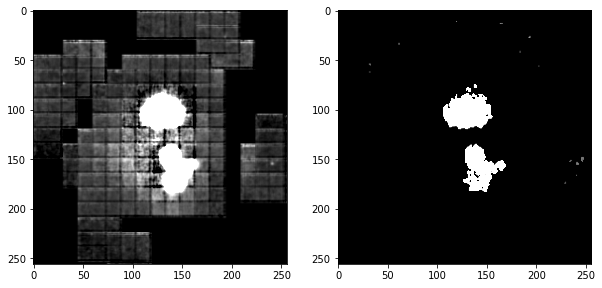

In [2]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(fe_map[:,:,90]*1000, cmap='gray', vmin=0, vmax=1)
ax[1].imshow(locscale_map[:,:,90]*1000, cmap='gray', vmin=0, vmax=1)

In [19]:
# single value decomposition 
i = 128
fe_slice = fe_map[:,:,i]
locscale_slice = locscale_map[:,:,i]

u_fe, s_fe, vh_fe = np.linalg.svd(fe_slice)
u_locscale, s_locscale, vh_locscale = np.linalg.svd(locscale_slice)
print("fe: min: {}, max: {}".format(np.min(s_fe), np.max(s_fe)))
print("locscale: min: {}, max: {}".format(np.min(s_locscale), np.max(s_locscale)))

fe: min: 1.469014954125214e-08, max: 7.467662334442139
locscale: min: 2.679453236454643e-17, max: 7.381222724914551


In [4]:
print(s_fe[7])

0.10502557


1
1


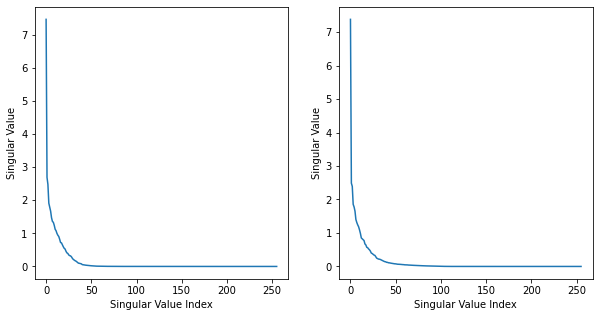

In [20]:
# plot the singular values
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(s_fe)
ax[1].plot(s_locscale)
ax[0].set_xlabel("Singular Value Index")
ax[1].set_xlabel("Singular Value Index")
ax[0].set_ylabel("Singular Value")
ax[1].set_ylabel("Singular Value")

# print the index corresponding to th
th = 5
print(np.where(s_fe < th)[0][0])
print(np.where(s_locscale < th)[0][0])


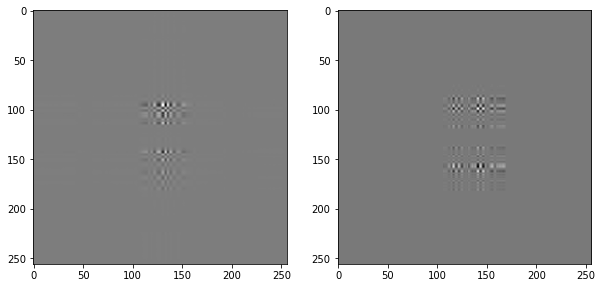

In [6]:
def get_nth_singular_order(U,S,Vt, n):
    u_n = U[:,n]
    v_n = Vt[n,:]
    s_n = S[n]

    return np.matmul(u_n.reshape(-1,1), v_n.reshape(1,-1)) * s_n

# plot the first singular order
fe_first_order = get_nth_singular_order(u_fe, s_fe, vh_fe, 10)
locscale_first_order = get_nth_singular_order(u_locscale, s_locscale, vh_locscale, 10)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(fe_first_order, cmap='gray')
ax[1].imshow(locscale_first_order, cmap='gray')


fe: min: -0.0076324716210365295, max: 0.007884878665208817
locscale: min: -0.01942511647939682, max: 0.02132086455821991


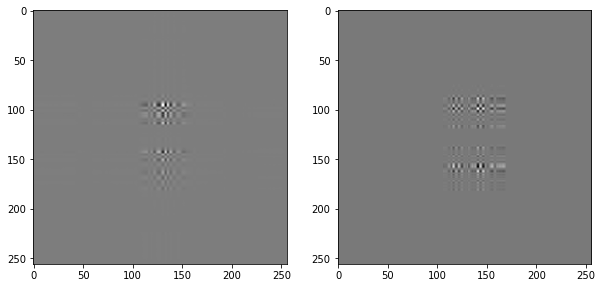

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
n = 10
ax[0].imshow(get_nth_singular_order(u_fe, s_fe, vh_fe, n), cmap='gray')
ax[1].imshow(get_nth_singular_order(u_locscale, s_locscale, vh_locscale, n), cmap='gray')
print("fe: min: {}, max: {}".format(np.min(get_nth_singular_order(u_fe, s_fe, vh_fe, n)), np.max(get_nth_singular_order(u_fe, s_fe, vh_fe, n))))
print("locscale: min: {}, max: {}".format(np.min(get_nth_singular_order(u_locscale, s_locscale, vh_locscale, n)), np.max(get_nth_singular_order(u_locscale, s_locscale, vh_locscale, n))))

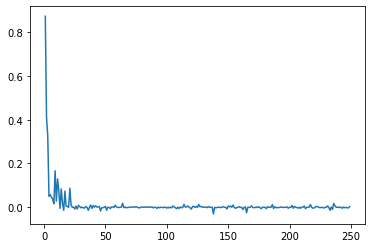

In [8]:
from locscale.include.emmer.ndimage.map_tools import compute_real_space_correlation
similarity_with_locscale = []
for n in range(1,250):
    fe_order = get_nth_singular_order(u_fe, s_fe, vh_fe, n)
    locscale_order = get_nth_singular_order(u_locscale, s_locscale, vh_locscale, n)
    similarity_with_locscale.append(compute_real_space_correlation(fe_order, locscale_order))

plt.plot(np.arange(1,250), similarity_with_locscale)

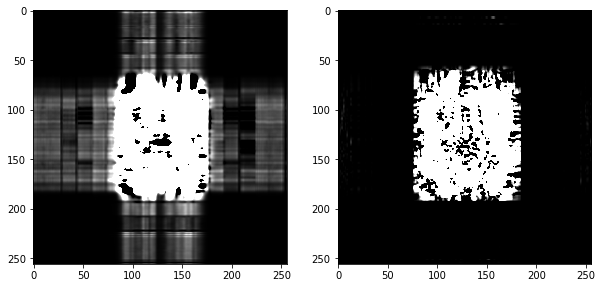

In [21]:
def filter_upper_singular_orders(U,S,Vt, n):
    u_n = U[:,:n]
    v_n = Vt[:n,:]
    s_n = S[:n]

    return np.matmul(u_n, np.matmul(np.diag(s_n), v_n))

fe_filtered = filter_upper_singular_orders(u_fe, s_fe, vh_fe, 5)
locscale_filtered = filter_upper_singular_orders(u_locscale, s_locscale, vh_locscale, 15)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(fe_filtered, cmap='gray', vmin=0, vmax=0.001)
ax[1].imshow(locscale_filtered, cmap='gray', vmin=0, vmax=0.001)

Text(0.5, 1.0, 'Filtered slice from FE')

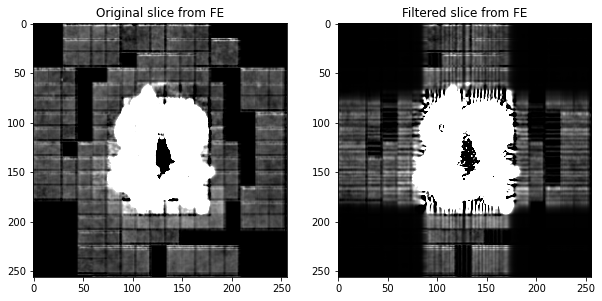

In [23]:
def filter_upto_significant_order(im, threshold=0.1):
    u, s, vh = np.linalg.svd(im)
    n = np.where(s < threshold)[0][0]
    return filter_upper_singular_orders(u, s, vh, n)

fe_filtered = filter_upto_significant_order(fe_slice)
locscale_filtered = filter_upto_significant_order(locscale_slice)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(fe_slice, cmap='gray', vmin=0, vmax=0.001)
ax[0].set_title("Original slice from FE")
ax[1].imshow(fe_filtered, cmap='gray', vmin=0, vmax=0.001)
ax[1].set_title("Filtered slice from FE")


In [11]:
def filter_emmap_by_significant_threshold(vol, th=0.1, axis=2):
    vol_filtered = np.zeros_like(vol)
    for i in range(vol.shape[axis]):
        if axis == 0:
            vol_filtered[i,:,:] = filter_upto_significant_order(vol[i,:,:], th)
        elif axis == 1:
            vol_filtered[:,i,:] = filter_upto_significant_order(vol[:,i,:], th)
        elif axis == 2:
            vol_filtered[:,:,i] = filter_upto_significant_order(vol[:,:,i], th)
    return vol_filtered

fe_filtered_map = filter_emmap_by_significant_threshold(fe_map)


fe_filtered_path = os.path.join(os.path.dirname(fe_path), "emd_0282_emmernet_output_mean_filtered.mrc")
save_as_mrc(fe_filtered_map, fe_filtered_path, apix)

In [12]:
def filter_cubing_artefacts(vol):
    axes = [0,1,2]
    vol_filtered = np.zeros_like(vol)
    for axis in axes:
        vol_f_axis = filter_emmap_by_significant_threshold(vol, axis=axis, th=10)
        vol_filtered += vol_f_axis
    return vol_filtered / 3

fe_filtered_map_3 = filter_emmap_by_significant_threshold(fe_map, th=0.1, axis=2)
fe_filtered_path_3 = os.path.join(os.path.dirname(fe_path), "emd_0282_emmernet_output_mean_filtered_cubing_axis2.mrc")

save_as_mrc(fe_filtered_map_3, fe_filtered_path_3, apix)



In [16]:
fe_filtered_map_3_again = filter_emmap_by_significant_threshold(fe_filtered_map_3, th=0.1, axis=1)
fe_filtered_path_3_again = os.path.join(os.path.dirname(fe_path), "emd_0282_emmernet_output_mean_filtered_cubing_axis2_againaxis1.mrc")

save_as_mrc(fe_filtered_map_3_again, fe_filtered_path_3_again, apix)

In [17]:
fe_filtered_map_3_again_again = filter_emmap_by_significant_threshold(fe_filtered_map_3_again, th=0.1, axis=0)
fe_filtered_path_3_again_again = os.path.join(os.path.dirname(fe_path), "emd_0282_emmernet_output_mean_filtered_cubing_axis2_againaxis1_againaxis0.mrc")

save_as_mrc(fe_filtered_map_3_again_again, fe_filtered_path_3_again_again, apix)

In [13]:
def extract_nth_modes(vol, n):
    vol_mode = np.zeros_like(vol)
    for i in range(vol.shape[2]):
        u, s, vh = np.linalg.svd(vol[:,:,i])
        nth_order = get_nth_singular_order(u, s, vh, n)
        vol_mode[:,:,i] = nth_order
    return vol_mode

fe_mode_1 = extract_nth_modes(fe_map, 1)
fe_mode_2 = extract_nth_modes(fe_map, 2)
fe_mode_3 = extract_nth_modes(fe_map, 3)

save_as_mrc(fe_mode_1, os.path.join(os.path.dirname(fe_path), "emd_0282_emmernet_output_mean_mode_1.mrc"), apix)
save_as_mrc(fe_mode_2, os.path.join(os.path.dirname(fe_path), "emd_0282_emmernet_output_mean_mode_2.mrc"), apix)
save_as_mrc(fe_mode_3, os.path.join(os.path.dirname(fe_path), "emd_0282_emmernet_output_mean_mode_3.mrc"), apix)


In [14]:
fe_map_fft = np.fft.fftshift(np.fft.fftn(fe_map))
fe_map_fft_abs = np.abs(fe_map_fft)
fe_map_fft_abs_log = np.log(fe_map_fft_abs)
save_as_mrc(fe_map_fft_abs_log, os.path.join(os.path.dirname(fe_path), "emd_0282_emmernet_output_mean_fft_abs_log.mrc"), apix)


In [15]:
locscale_map_fft = np.fft.fftshift(np.fft.fftn(locscale_map))
locscale_map_fft_abs = np.abs(locscale_map_fft)
locscale_map_fft_abs_log = np.log(locscale_map_fft_abs)
save_as_mrc(locscale_map_fft_abs_log, os.path.join(os.path.dirname(fe_path), "emd_0282_emmernet_output_locscale_output_fft_abs_log.mrc"), apix)


/home/abharadwaj1/miniconda3/envs/locscale_dev/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/home/abharadwaj1/miniconda3/envs/locscale_dev/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


KeyboardInterrupt: 

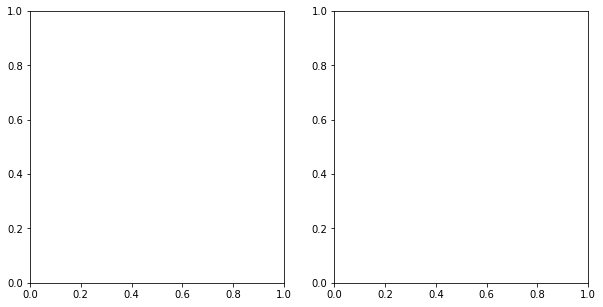

In [121]:
import seaborn as sns


